# Meridional Overturning Circulation

Global Ocean transport depictions often involve concepts like the [AMOC](https://en.wikipedia.org/wiki/Atlantic_meridional_overturning_circulation), [Thermohaline Circulation](https://en.wikipedia.org/wiki/Thermohaline_circulation), or [conveyor Belt](http://oceanmotion.org/html/background/ocean-conveyor-belt.html). To apply these concepts to gridded ocean and climate models, one can compute an `overturning streamfunction` as shown below. For more detail, please refer to [Forget et al, 2015](https://doi.org/10.5194/gmd-8-3071-2015) and the other [GlobalOceanNotebooks](https://github.com/JuliaClimate/GlobalOceanNotebooks).

### Read grid & velocities from file

1. pre-requisites
2. read variables
3. conversion to transports

In [1]:
using MeshArrays, Plots, Statistics
include("helper_functions.jl")

pth=MeshArrays.GRID_LLC90
γ=GridSpec("LatLonCap",pth)
Γ=GridLoad(γ)
LC=LatitudeCircles(-89.0:89.0,Γ);

using MeshArrays, Plots, Statistics, MITgcmTools

include("helper_functions.jl")
get_grid_if_needed()
get_velocity_if_needed()

Γ =read_llc90_grid()
LC=LatitudeCircles(-89.0:89.0,Γ);

### Compute Overturning Streamfunction

1. integrate across `latitude circle paths`
2. integrate from the bottom

In [2]:
nz=size(Γ["hFacC"],2); nt=12; nl=length(LC)
ov=Array{Float64,3}(undef,nl,nz,nt)

#integrate across latitude circles
for t=1:nt
    (U,V)=read_velocities(Γ["XC"].grid,t)
    (U,V)=convert_velocities(U,V,Γ)
    for z=1:nz
        UV=Dict("U"=>U[:,z],"V"=>V[:,z],"dimensions"=>["x","y"])
        [ov[l,z,t]=ThroughFlow(UV,LC[l],Γ) for l=1:nl]
    end
end

#integrate from bottom
ov=reverse(cumsum(reverse(ov,dims=2),dims=2),dims=2);

### Plot Annual Mean And Variability

In [3]:
x=vec(-89.0:89.0); y=reverse(vec(Γ["RF"][1:end-1])); #coordinate variables

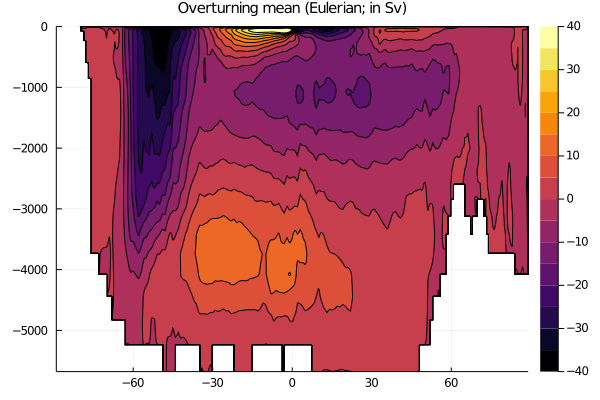

In [4]:
tmp=dropdims(mean(ov,dims=3),dims=3)
z=reverse(tmp,dims=2); z[z.==0.0].=NaN

contourf(x,y,1e-6*transpose(z),clims=(-40,40),
    title="Overturning mean (Eulerian; in Sv)",titlefontsize=10)
#savefig("MOC_mean.png")

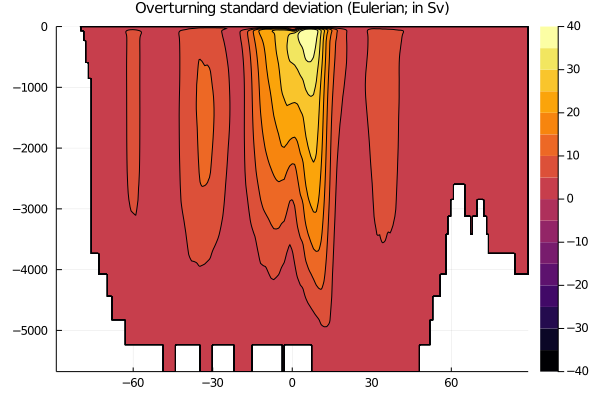

In [5]:
tmp=dropdims(std(ov,dims=3),dims=3)
z=reverse(tmp,dims=2); z[z.==0.0].=NaN

contourf(x,y,1e-6*transpose(z),clims=(-40,40),
    title="Overturning standard deviation (Eulerian; in Sv)",titlefontsize=10)
#savefig("MOC_std.png")